# C1 W1 Group 8

In [149]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import pandas as pd

from src.data import GT_QSD1_W1_LIST
from src.paths import BBDD_PATH, QSD1_W1_PATH, QST1_W1_PATH, WEEK_1_RESULTS_PATH
from src.descriptors import GreyScaleHistogramDescriptor1D, ColorHistogramDescriptor1D, MultiColorSpaceHistogramDescriptor1D
from src.similarities import MSE, L1Distance, ChiSquaredDistance, HistogramIntersection, HellingerKernel, Bhattacharyya
from src.metrics import MeanAveragePrecisionAtK

## Task 1 - Create Museum and query image descriptors (BBDD & QSD1)

The functions in this section are required to take a PIL.Image object as input and return a 1D descriptor in the form of a NumPy array. Inside the function, you have the freedom to implement any processing or transformation steps as long as the input and output types are respected. Specifically:

    Input: A PIL.Image object, which can be manipulated or processed as needed.
    Output: A 1D descriptor, represented as a NumPy array, which could be a histogram, feature vector, or any other type of descriptor derived from the input image.

In [150]:
# Replace with the function you want to use to generate the descriptors

descriptors_classes = [
    #GreyScaleHistogramDescriptor1D(),
    #ColorHistogramDescriptor1D('RGB'),
    #ColorHistogramDescriptor1D('HSV'),
    #ColorHistogramDescriptor1D('LAB'),
    #ColorHistogramDescriptor1D('YCbCr'),
    MultiColorSpaceHistogramDescriptor1D(['HSV', 'LAB']),
    MultiColorSpaceHistogramDescriptor1D(['HSV', 'LAB'], histogram_type='log-chromatic'),
    MultiColorSpaceHistogramDescriptor1D(['HSV', 'LAB', 'YCbCr']),
    MultiColorSpaceHistogramDescriptor1D(['HSV', 'LAB', 'YCbCr'], histogram_type='log-chromatic')
]

In [151]:
# Database image descriptors

database_image_PIL_list = [Image.open(db_img_path) for db_img_path in sorted(BBDD_PATH.glob("*.jpg"))]  # Load once
for idx, db_img in enumerate(database_image_PIL_list):
    assert db_img.filename.endswith(f"{idx}.jpg")
database_image_descriptors_list = [np.array([descriptor.compute(database_image_PIL) for database_image_PIL in database_image_PIL_list]) for descriptor in descriptors_classes]

In [152]:
# Query image descriptors

query_image_PIL_list = [Image.open(query_img_path) for query_img_path in sorted(QSD1_W1_PATH.glob("*.jpg"))]  # Load once
for idx, query_img in enumerate(query_image_PIL_list):
    assert query_img.filename.endswith(f"{idx}.jpg")
query_image_descriptors_list = [np.array([descriptor.compute(query_image_PIL) for query_image_PIL in query_image_PIL_list]) for descriptor in descriptors_classes]

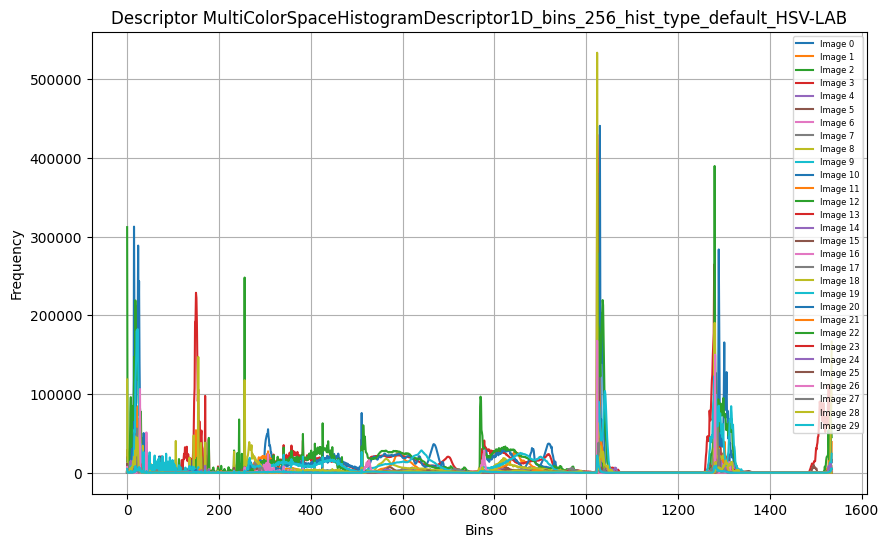

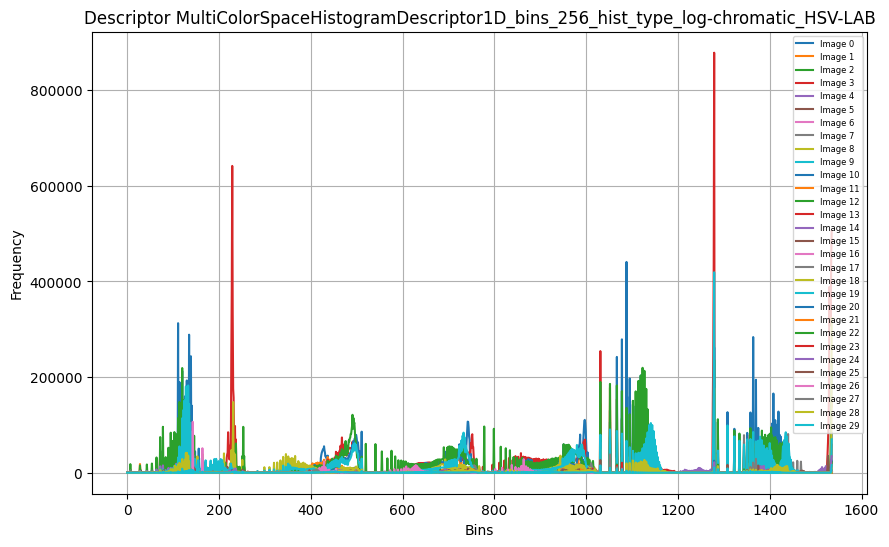

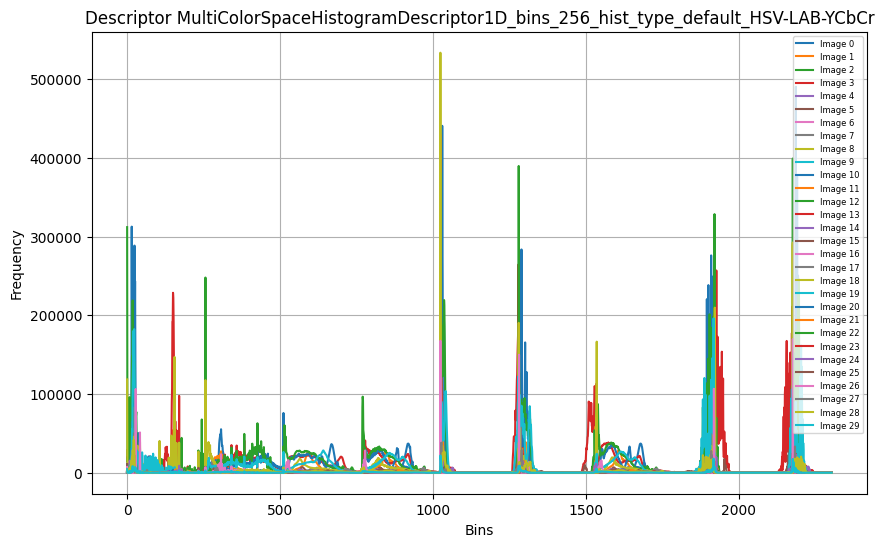

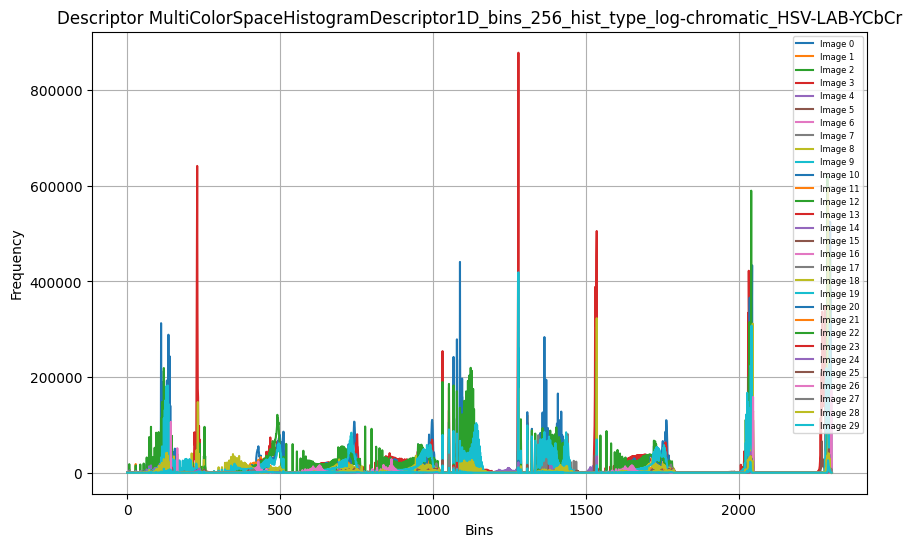

In [153]:
for idx, query_image_descriptors in enumerate(query_image_descriptors_list):
    bins = np.arange(query_image_descriptors.shape[1])
    plt.figure(figsize=(10, 6))
    for i, hist in enumerate(query_image_descriptors):
        plt.plot(bins, hist, label=f'Image {i}')
    plt.title(f'Descriptor {descriptors_classes[idx].name}')
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.legend(fontsize=6, loc='upper right')
    plt.grid(True)
    plt.show()

## Task 2 - Implement / compute similarity measures to compare images

In this section, the functions should implement various distance measures between query descriptors and database descriptors. The input for both the query and database will be a 2D NumPy array, where each row represents the descriptor of one image. Specifically:

    Query descriptors will have shape (N, K), where N is the number of query images, and K is the length of each descriptor.
    Database descriptors will have shape (M, K), where M is the number of database images, and K is the length of each descriptor.

The output should be a 2D array of shape (N, M), where each entry (i, j) represents the distance between query descriptor N_i and database descriptor M_j.

In [154]:
similarity_classes = [
    #MSE(),
    #L1Distance(),
    #ChiSquaredDistance(),
    HistogramIntersection(),
    HellingerKernel(),
    Bhattacharyya()
]

In [155]:
query_descriptor_distances_to_bbdd_list = []
for query_descriptors, database_descriptors in zip(query_image_descriptors_list, database_image_descriptors_list):
    query_distances_to_bbdd = []
    for similarity_function in similarity_classes:
        query_distances_to_bbdd.append(similarity_function.compute(query_descriptors, database_descriptors))
    query_descriptor_distances_to_bbdd_list.append(query_distances_to_bbdd)

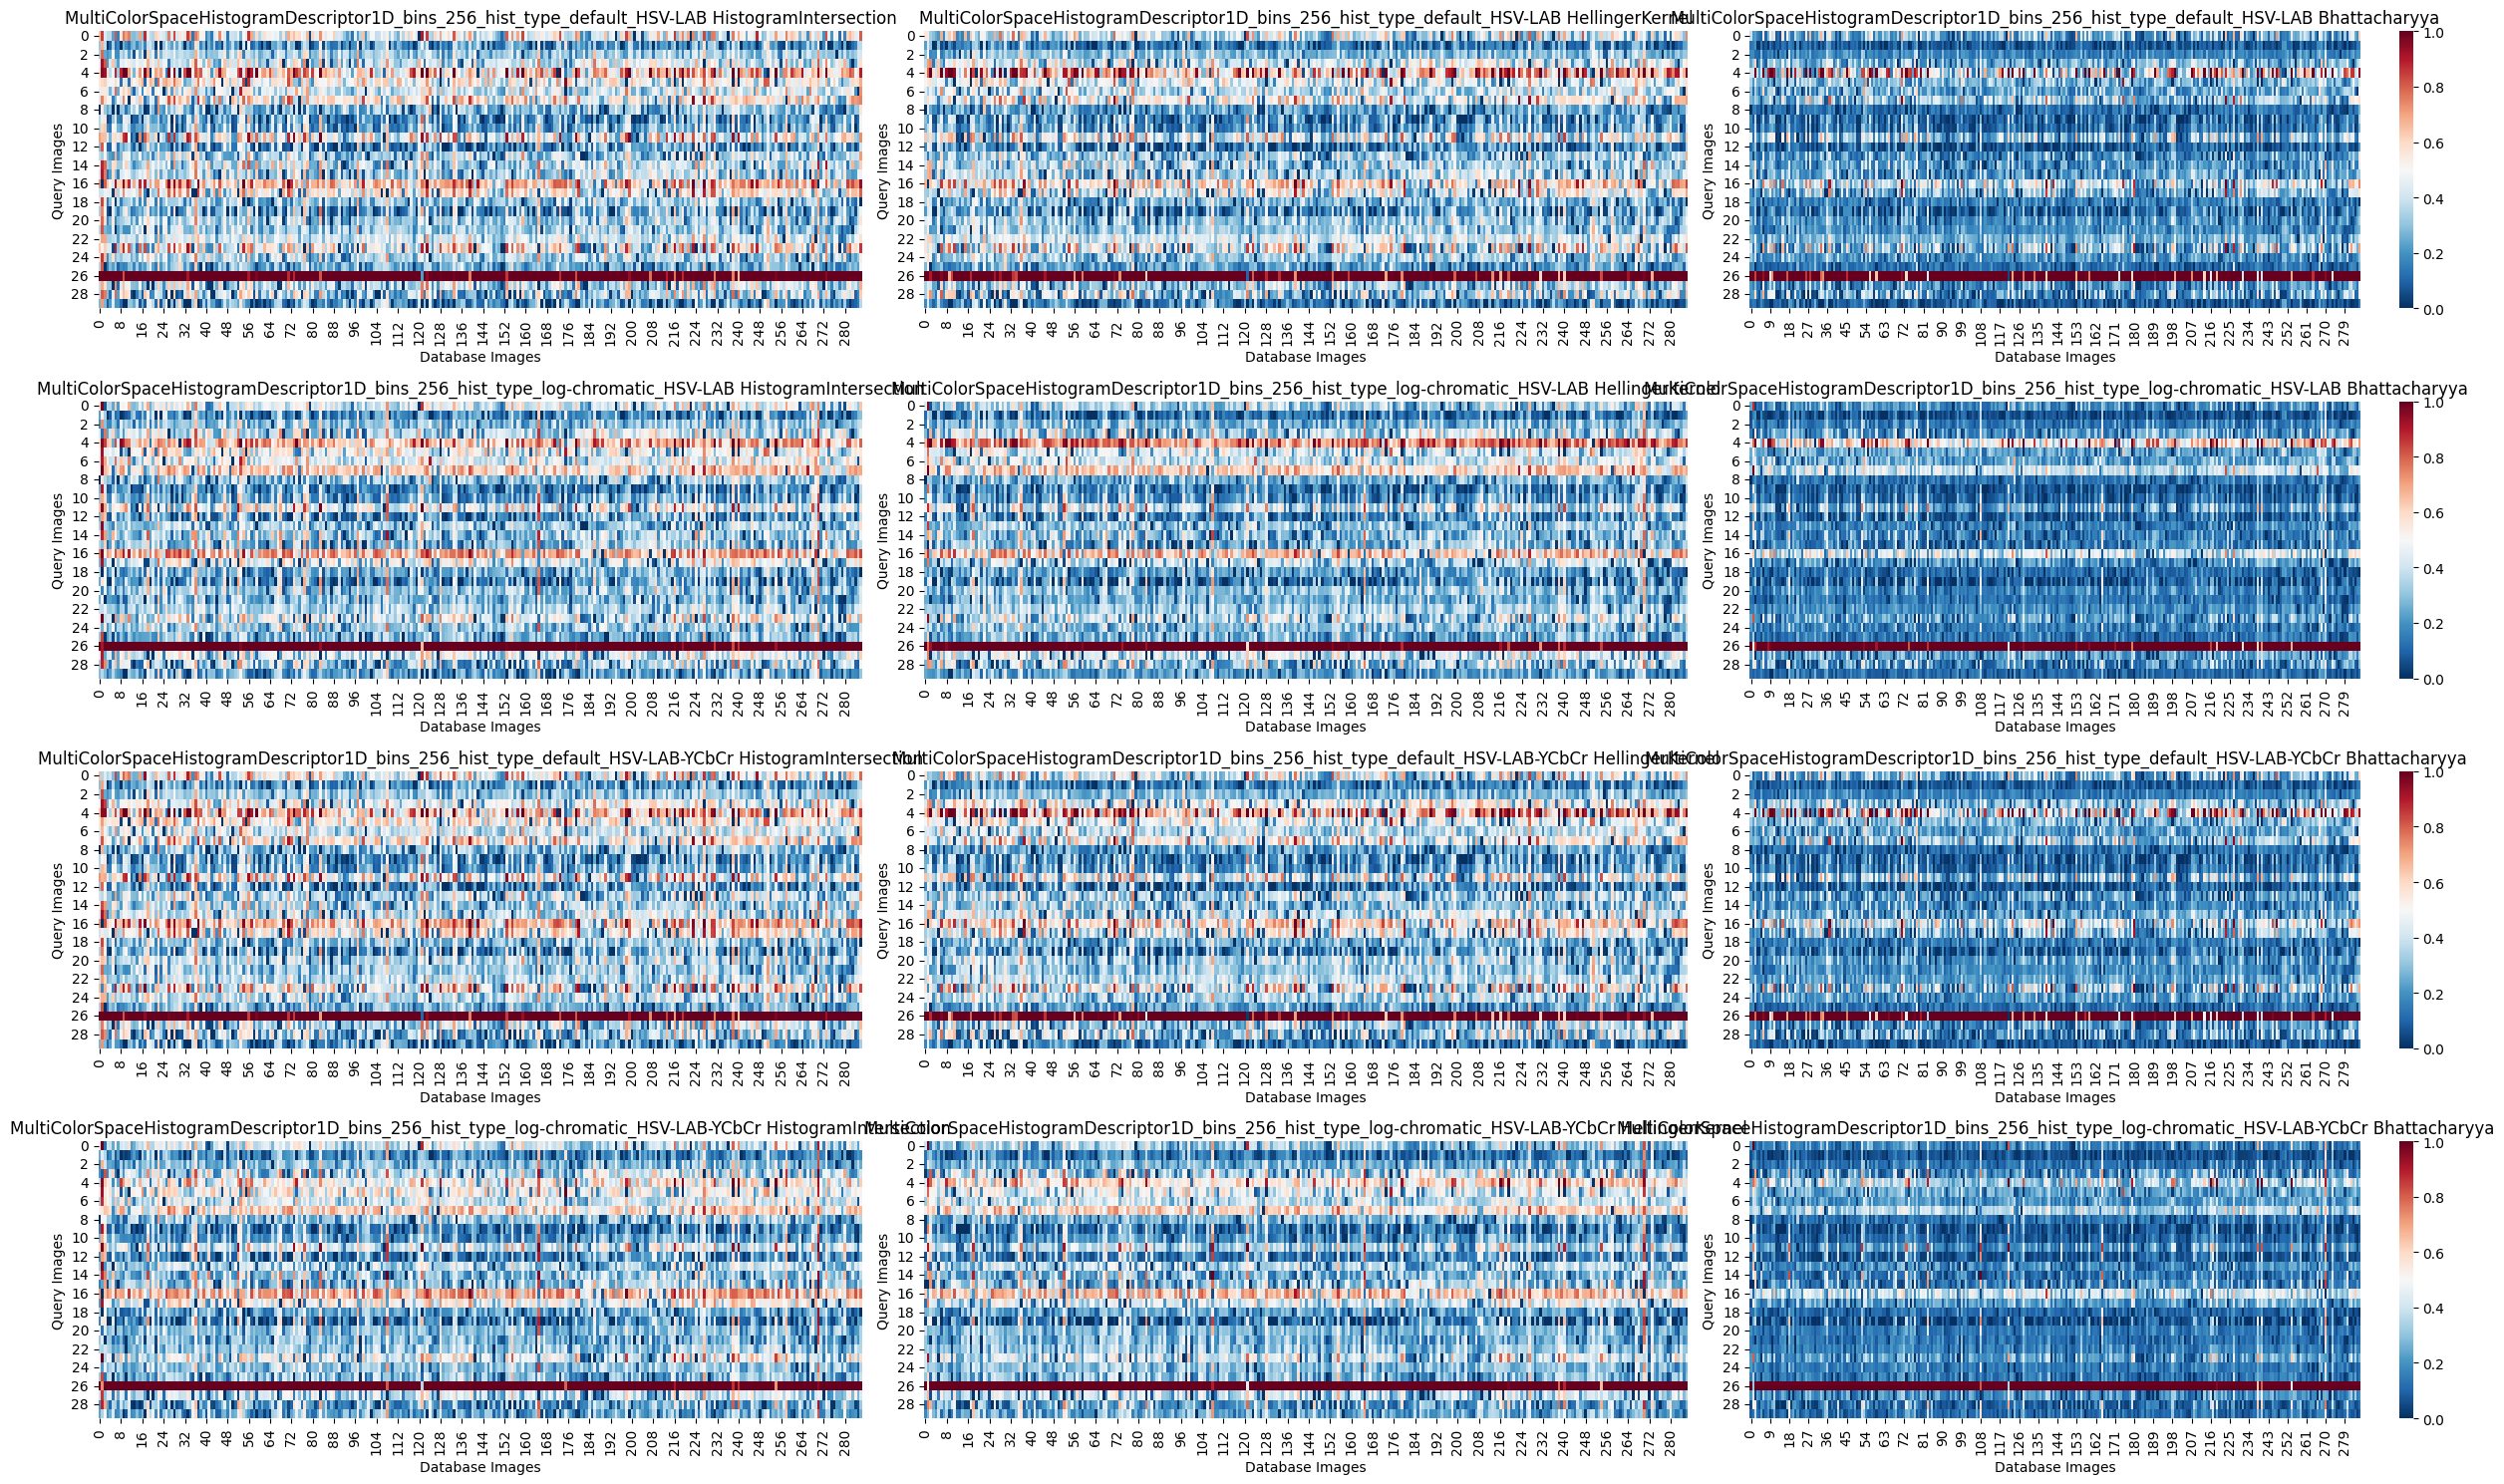

In [156]:

n_rows = len(descriptors_classes)
n_cols = len(similarity_classes)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 15))  

if n_rows == 1:
    axes = axes.reshape(1, -1)  # Convert to 2D array with 1 row
elif n_cols == 1:
    axes = axes.reshape(-1, 1)  # Convert to 2D array with 1 column

for i, descriptor in enumerate(descriptors_classes):
    for j, similarity in enumerate(similarity_classes):
        query_distances_to_bbdd = query_descriptor_distances_to_bbdd_list[i][j]
        
        # Normalize the distances
        normalized_query_distances = (query_distances_to_bbdd - query_distances_to_bbdd.min(axis=0)) / (query_distances_to_bbdd.max(axis=0) - query_distances_to_bbdd.min(axis=0))
        
        # Select the subplot axes for the current descriptor-similarity pair
        ax = axes[i, j]
        
        sns.heatmap(normalized_query_distances, cmap="RdBu_r", cbar=(j == n_cols - 1), ax=ax)
        
        ax.set_xlabel('Database Images')
        ax.set_ylabel('Query Images')
        ax.set_title(f'{descriptor.name} {similarity.__class__.__name__}')
        
plt.tight_layout()

plt.show()

## Task 3 - Implement retrieval system (retrieve top K results)

In [157]:
def get_topk_distances(query_distances_to_bbdd: np.array, k: int = 1) -> tuple[list[list], list[list]]:
    retrieved_bbdd_indices = np.argsort(query_distances_to_bbdd, axis=1)[:, :k]
    
    retrieved_bbdd_similarity = np.take_along_axis(query_distances_to_bbdd, retrieved_bbdd_indices, axis=1)
    
    return retrieved_bbdd_indices.tolist(), retrieved_bbdd_similarity.tolist()

In [158]:
K = [1,5]

In [159]:
retrieved_bbdd_indices_list, retrieved_bbdd_similarity_list = [[],[]], [[],[]]
for i, k in enumerate(K):
    for query_descriptor_distances_to_bbdd in query_descriptor_distances_to_bbdd_list:
        retrieved_bbdd_indices_tmp, retrieved_bbdd_similarity_tmp = [], []
        for query_distances_to_bbdd in query_descriptor_distances_to_bbdd:
            retrieved_bbdd_indices, retrieved_bbdd_similarity = get_topk_distances(query_distances_to_bbdd, k=k)
            retrieved_bbdd_indices_tmp.append(retrieved_bbdd_indices)
            retrieved_bbdd_similarity_tmp.append(retrieved_bbdd_similarity)
        retrieved_bbdd_indices_list[i].append(retrieved_bbdd_indices_tmp)
        retrieved_bbdd_similarity_list[i].append(retrieved_bbdd_similarity_tmp)

In [160]:
metrics = [MeanAveragePrecisionAtK()]

results = []

for i,k in enumerate(K):
    for metric in metrics:
        print(f"K={k}, {metric.__class__.__name__} results:")
        for descriptor, retrieved_bbdd_indices, retrieved_bbdd_similarity in zip(descriptors_classes, retrieved_bbdd_indices_list[i], retrieved_bbdd_similarity_list[i]):
            print(f"  - {descriptor.name}")
            for similarity, retrieved_similarity_bbdd_indices, retrieved_similarity_bbdd_similarity in zip(similarity_classes, retrieved_bbdd_indices, retrieved_bbdd_similarity):
                out = metric.compute(GT_QSD1_W1_LIST, retrieved_similarity_bbdd_indices)  # Slice based on k
                print(f"      -> {similarity.__class__.__name__}: {out}")
                results.append({
                    "K": k,
                    "Metric": metric.__class__.__name__,
                    "Descriptor": descriptor.name,
                    "Similarity": similarity.__class__.__name__,
                    "Result": out,
                    "Indices": retrieved_similarity_bbdd_indices,
                    "Descriptor_id" : descriptor,
                    "Similarity_id" : similarity
                })

results_df = pd.DataFrame(results)

results_df.drop(columns=["Indices", "Descriptor_id", "Similarity_id"], errors='ignore')



K=1, MeanAveragePrecisionAtK results:
  - MultiColorSpaceHistogramDescriptor1D_bins_256_hist_type_default_HSV-LAB
      -> HistogramIntersection: 0.5
      -> HellingerKernel: 0.43333333333333335
      -> Bhattacharyya: 0.43333333333333335
  - MultiColorSpaceHistogramDescriptor1D_bins_256_hist_type_log-chromatic_HSV-LAB
      -> HistogramIntersection: 0.5333333333333333
      -> HellingerKernel: 0.43333333333333335
      -> Bhattacharyya: 0.43333333333333335
  - MultiColorSpaceHistogramDescriptor1D_bins_256_hist_type_default_HSV-LAB-YCbCr
      -> HistogramIntersection: 0.43333333333333335
      -> HellingerKernel: 0.4
      -> Bhattacharyya: 0.4
  - MultiColorSpaceHistogramDescriptor1D_bins_256_hist_type_log-chromatic_HSV-LAB-YCbCr
      -> HistogramIntersection: 0.6
      -> HellingerKernel: 0.6
      -> Bhattacharyya: 0.6
K=5, MeanAveragePrecisionAtK results:
  - MultiColorSpaceHistogramDescriptor1D_bins_256_hist_type_default_HSV-LAB
      -> HistogramIntersection: 0.564444444444444

,K,Metric,Descriptor,Similarity,Result
0,1,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,HistogramIntersection,0.500000
1,1,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,HellingerKernel,0.433333
2,1,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,Bhattacharyya,0.433333
3,1,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,HistogramIntersection,0.533333
4,1,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,HellingerKernel,0.433333
5,1,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,Bhattacharyya,0.433333
6,1,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,HistogramIntersection,0.433333
7,1,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,HellingerKernel,0.400000
8,1,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,Bhattacharyya,0.400000
9,1,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,HistogramIntersection,0.600000


In [161]:
k5_results = results_df[results_df['K'] == 5]
top_2_metrics_k5 = k5_results.nlargest(2, 'Result')

best_metrics_k5 = top_2_metrics_k5[['Metric', 'Descriptor', 'Similarity','Indices']]

final_results = results_df[(results_df['K'].isin([1, 5])) & 
                           (results_df['Metric'].isin(best_metrics_k5['Metric'])) & 
                           (results_df['Descriptor'].isin(best_metrics_k5['Descriptor'])) & 
                           (results_df['Similarity'].isin(best_metrics_k5['Similarity'])) ]

final_results.drop(columns=["Indices", "Descriptor_id", "Similarity_id"], errors='ignore')

,K,Metric,Descriptor,Similarity,Result
9,1,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,HistogramIntersection,0.600000
10,1,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,HellingerKernel,0.600000
21,5,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,HistogramIntersection,0.658333
22,5,MeanAveragePrecisionAtK,MultiColorSpaceHistogramDescriptor1D_bins_256_...,HellingerKernel,0.651111


In [162]:
method1_indices = list(final_results[final_results['K']==K[1]]['Indices'])[0]

method1_descriptor = list(final_results[final_results['K']==K[1]]['Descriptor_id'])[0]
method2_descriptor = list(final_results[final_results['K']==K[1]]['Descriptor_id'])[1]

method1_similarity = list(final_results[final_results['K']==K[1]]['Similarity_id'])[0]
method2_similarity = list(final_results[final_results['K']==K[1]]['Similarity_id'])[1]

Visualization for method 1, k = 5

In [ ]:
n = len(GT_QSD1_W1_LIST)  # Number of rows (ground truth images)

fig, axs = plt.subplots(n, k + 2, figsize=(3 * (k + 2), 3 * n))

for i in range(n):
    query_image_path = QSD1_W1_PATH / f"{str(i).zfill(5)}.jpg"
    query_image_PIL = Image.open(query_image_path)

    axs[i, 0].imshow(query_image_PIL)
    axs[i, 0].set_title(f"QUERY - {query_image_path.name}")
    axs[i, 0].axis('off')

    gt_idx = GT_QSD1_W1_LIST[i][0]  # only one index in GT
    database_image_path = BBDD_PATH / f"bbdd_{str(gt_idx).zfill(5)}.jpg"
    database_image_PIL = Image.open(database_image_path)

    axs[i, 1].imshow(database_image_PIL)
    axs[i, 1].set_title(f"BBDD: {database_image_path.name}")
    axs[i, 1].axis('off')

    for j in range(K[1]): # k = 5
        retrieved_idx = method1_indices[i][j] # first method
        retrieved_image_path = BBDD_PATH / f"bbdd_{str(retrieved_idx).zfill(5)}.jpg"
        retrieved_image_PIL = Image.open(retrieved_image_path)
        axs[i, j + 2].imshow(retrieved_image_PIL)
        axs[i, j + 2].set_title(f"PRED {j} - {retrieved_image_path.name}")
        axs[i, j + 2].axis('off')

# Adjust layout
plt.tight_layout()
plt.savefig((WEEK_1_RESULTS_PATH / "validation_set_retrieval.png").as_posix())
plt.close()

## Task 4 - Create predictions for blind challenge (QST1)

In [164]:
# Apply method 1 and method 2 descriptor and similarity to BBDD

database_image_PIL_list = [Image.open(db_img_path) for db_img_path in sorted(BBDD_PATH.glob("*.jpg"))]  # Load once
for idx, db_img in enumerate(database_image_PIL_list):
    assert db_img.filename.endswith(f"{idx}.jpg")

database_descriptors_1 = np.array([method1_descriptor.compute(database_image_PIL) for database_image_PIL in database_image_PIL_list])
database_descriptors_2 = np.array([method2_descriptor.compute(database_image_PIL) for database_image_PIL in database_image_PIL_list])

In [165]:
# Apply method 1 and method 2 descriptor and similarity to test set

test_image_PIL_list = [Image.open(db_img_path) for db_img_path in sorted(QST1_W1_PATH.glob("*.jpg"))]  # Load once
for idx, test_img in enumerate(test_image_PIL_list):
    assert test_img.filename.endswith(f"{idx}.jpg")

k = 10 

# method 1
test_image_descriptors_1 = np.array([method1_descriptor.compute(test_image_PIL) for test_image_PIL in test_image_PIL_list])
test_distances_to_bbdd_1 = method1_similarity.compute(test_image_descriptors_1, database_descriptors)
test_retrieved_bbdd_indices_1, test_retrieved_bbdd_similarity_1 = get_topk_distances(test_distances_to_bbdd_1, k = k)

# method 2
test_image_descriptors_2 = np.array([method1_descriptor.compute(test_image_PIL) for test_image_PIL in test_image_PIL_list])
test_distances_to_bbdd_2 = method1_similarity.compute(test_image_descriptors_2, database_descriptors)
test_retrieved_bbdd_indices_2, test_retrieved_bbdd_similarity_2 = get_topk_distances(test_distances_to_bbdd_2, k = k)

In [166]:
# Method 1 
print(f"Descriptor {method1_descriptor.name} - Similarity {method1_similarity.__class__.__name__}: \n {test_retrieved_bbdd_indices_1}")

# Method 2 
print(f"Descriptor {method2_descriptor.name} - Similarity {method2_similarity.__class__.__name__}: \n {test_retrieved_bbdd_indices_2}")


Descriptor MultiColorSpaceHistogramDescriptor1D_bins_256_hist_type_log-chromatic_HSV-LAB-YCbCr - Similarity HistogramIntersection: 
 [[276, 235, 170, 225, 154, 82, 174, 31, 51, 130], [79, 152, 272, 151, 95, 222, 236, 188, 226, 12], [155, 140, 76, 144, 88, 103, 122, 227, 96, 72], [22, 12, 51, 137, 205, 29, 262, 174, 145, 14], [157, 133, 170, 218, 64, 57, 10, 185, 31, 244], [23, 51, 4, 225, 228, 244, 119, 195, 58, 241], [251, 177, 100, 40, 172, 19, 250, 112, 142, 70], [110, 242, 185, 187, 246, 151, 31, 170, 257, 138], [215, 39, 239, 163, 29, 51, 253, 82, 276, 103], [208, 212, 280, 68, 152, 52, 41, 79, 98, 73], [259, 31, 192, 276, 154, 29, 39, 170, 88, 130], [184, 79, 205, 12, 93, 137, 236, 98, 22, 235], [165, 52, 41, 77, 85, 208, 18, 108, 68, 146], [258, 35, 279, 127, 125, 208, 49, 209, 106, 10], [100, 20, 183, 226, 24, 141, 251, 67, 68, 206], [155, 140, 122, 76, 103, 144, 84, 96, 227, 69], [110, 185, 242, 240, 246, 254, 146, 77, 208, 31], [170, 241, 130, 31, 64, 160, 235, 242, 126, 276]

Visualization for Method 1

In [167]:
# Plot the images in a subplot
n = len(GT_QSD1_W1_LIST)  # Number of rows (ground truth images)

# Create a figure with n rows and k+1 columns (for the GT and N pred images)
fig, axs = plt.subplots(n, k + 1, figsize=(3 * (k + 1), 3 * n))

# Loop through each ground truth and predicted images
for i in range(n):
    # Load ground truth image
    query_image_path = QST1_W1_PATH / f"{str(i).zfill(5)}.jpg"
    query_image_PIL = Image.open(query_image_path)

    # Plot ground truth image in the first column
    axs[i, 0].imshow(query_image_PIL)
    axs[i, 0].set_title(f"QUERY - {query_image_path.name}")
    axs[i, 0].axis('off')

    # Loop through the retrieved images
    for j in range(k):
        retrieved_idx = test_retrieved_bbdd_indices_1[i][j]  # Method 1 k=5
        retrieved_image_path = BBDD_PATH / f"bbdd_{str(retrieved_idx).zfill(5)}.jpg"
        retrieved_image_PIL = Image.open(retrieved_image_path)
        axs[i, j + 1].imshow(retrieved_image_PIL)
        axs[i, j + 1].set_title(f"PRED {j} - {retrieved_image_path.name}")
        axs[i, j + 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.savefig((WEEK_1_RESULTS_PATH / "test_set_retrieval.png").as_posix())
plt.close()